In [1]:
from statistics import mean, stdev, mode
import torch

import sys
sys.path.append('../')

from models.vae import train_vanilla_vae, train_beta_vae, train_factor_vae
from tools.gp_manifold_generator import sample_points
from flatnet import train
import matplotlib.pyplot as plt
import skdim
import pytorch_lightning as pl

%matplotlib notebook

np = lambda z: z.cpu().detach().numpy()

pl.seed_everything(20)

/Users/druv/miniforge3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/druv/miniforge3/envs/torch/lib/python3.10/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE'
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 20


20

In [2]:
def plot_X_Z_Xhat_interpolated_2d(X, Z, Xhat, G, title="", N_interp=10000):
    
    randindices = torch.randint(low=0, high=Z.shape[0], size=(N_interp, 2))
    Z_interp = (Z[randindices[:, 0]] + Z[randindices[:, 1]])/2
    Xhat_interp = G(Z_interp)
    
    if Z.shape[1] < X.shape[1]:
        d_remaining = X.shape[1] - Z.shape[1]
        Z = torch.cat((Z, torch.zeros(Z.shape[0], d_remaining)), dim=1)
        Z_interp = torch.cat((Z_interp, torch.zeros(Z_interp.shape[0], d_remaining)), dim=1)
    
    X = np(X)
    Z = np(Z)
    Xhat = np(Xhat)
    Z_interp = np(Z_interp)
    Xhat_interp = np(Xhat_interp)
    
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(1, 1, 1)
    
    # Make everything invisible
    ax.axis("off")
    
    # ax.scatter(Z_interp[:, 0], Z_interp[:, 1], s=2 color="C1", alpha=0.3)
    ax.scatter(Xhat_interp[:, 0], Xhat_interp[:, 1], s=2, color="C2", alpha=0.3)
    
    ax.scatter(X[:, 0], X[:, 1], s=6, color="C0", label="$X$")
    ax.scatter(Z[:, 0], Z[:, 1], s=6, color="C1", label="$Z$")
    ax.scatter(Xhat[:, 0], Xhat[:, 1], s=2, color="C2", label="Interpolated $\hat{X}$", alpha=0.3)
    
    ax.legend()
    
    ax.set_title(title)

In [3]:
def plot_X_Z_Xhat_interpolated_3d(X, Z, Xhat, G, title="", N_interp=10000):
    randindices = torch.randint(low=0, high=Z.shape[0], size=(N_interp, 3))
    Z_interp = (Z[randindices[:, 0]] + Z[randindices[:, 1]] + Z[randindices[:, 2]])/3
    Xhat_interp = G(Z_interp)
    
    if Z.shape[1] < X.shape[1]:
        d_remaining = X.shape[1] - Z.shape[1]
        Z = torch.cat((Z, torch.zeros(Z.shape[0], d_remaining)), dim=1)
        Z_interp = torch.cat((Z_interp, torch.zeros(Z_interp.shape[0], d_remaining)), dim=1)
    
    X = np(X)
    Z = np(Z)
    Xhat = np(Xhat)
    Z_interp = np(Z_interp)
    Xhat_interp = np(Xhat_interp)
    
    plt.figure(figsize=(12, 3))
    ax1 = plt.subplot(1, 5, 1, projection="3d")
    ax2 = plt.subplot(1, 5, 2, projection="3d")
    ax3 = plt.subplot(1, 5, 3, projection="3d")
    ax4 = plt.subplot(1, 5, 4, projection="3d")
    ax5 = plt.subplot(1, 5, 5, projection="3d")
    
    for ax in [ax1, ax2, ax3, ax4, ax5]:
        # Make panes transparent
        ax.xaxis.pane.fill = False # Left pane
        ax.yaxis.pane.fill = False # Right pane

        # Remove grid lines
        ax.grid(False)

        # Remove tick labels
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])

        # Transparent spines
        ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
        ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

        # Transparent panes
        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

        # No ticks
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_zticks([])
    
    
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], s=4, color="C0")
    ax1.set_title("$X$")
    
    ax2.scatter(Z[:, 0], Z[:, 1], Z[:, 2], s=4, color="C1")
    ax2.set_title("$Z$")
        
    ax3.scatter(Z_interp[:, 0], Z_interp[:, 1], Z_interp[:, 2], s=3, color="C1")
    ax3.set_title("$Z$ interpolated")
        
    ax4.scatter(Xhat[:, 0], Xhat[:, 1], Xhat[:, 2], s=4, color="C2")
    ax4.set_title("$\hat{X}$")
    
    ax5.scatter(Xhat_interp[:, 0], Xhat_interp[:, 1], Xhat_interp[:, 2], s=3, color="C2")
    ax5.set_title("$\hat{X}$ interpolated")
    
    plt.suptitle(title)

In [4]:
L_manifoldgen = 10.0

# different epoch # is to stop degeneracy
N_vanillavae_epochs = 100
N_betavae_epochs = 100
N_factorvae_epochs = 100

D_vae_latent = 100

In [5]:
N = 50
D = 2
d = 1

X, P, d = sample_points(N, D, d, [L_manifoldgen for _ in range(D)])

In [6]:
F, G = train(X)
Z = F(X)
Xhat = G(Z)

100%|█| 500/500 [01:16<00:00,  6.51iters/s, local_recon=7.25e-9, d=1, r_ratio=1,


<IPython.core.display.Javascript object>


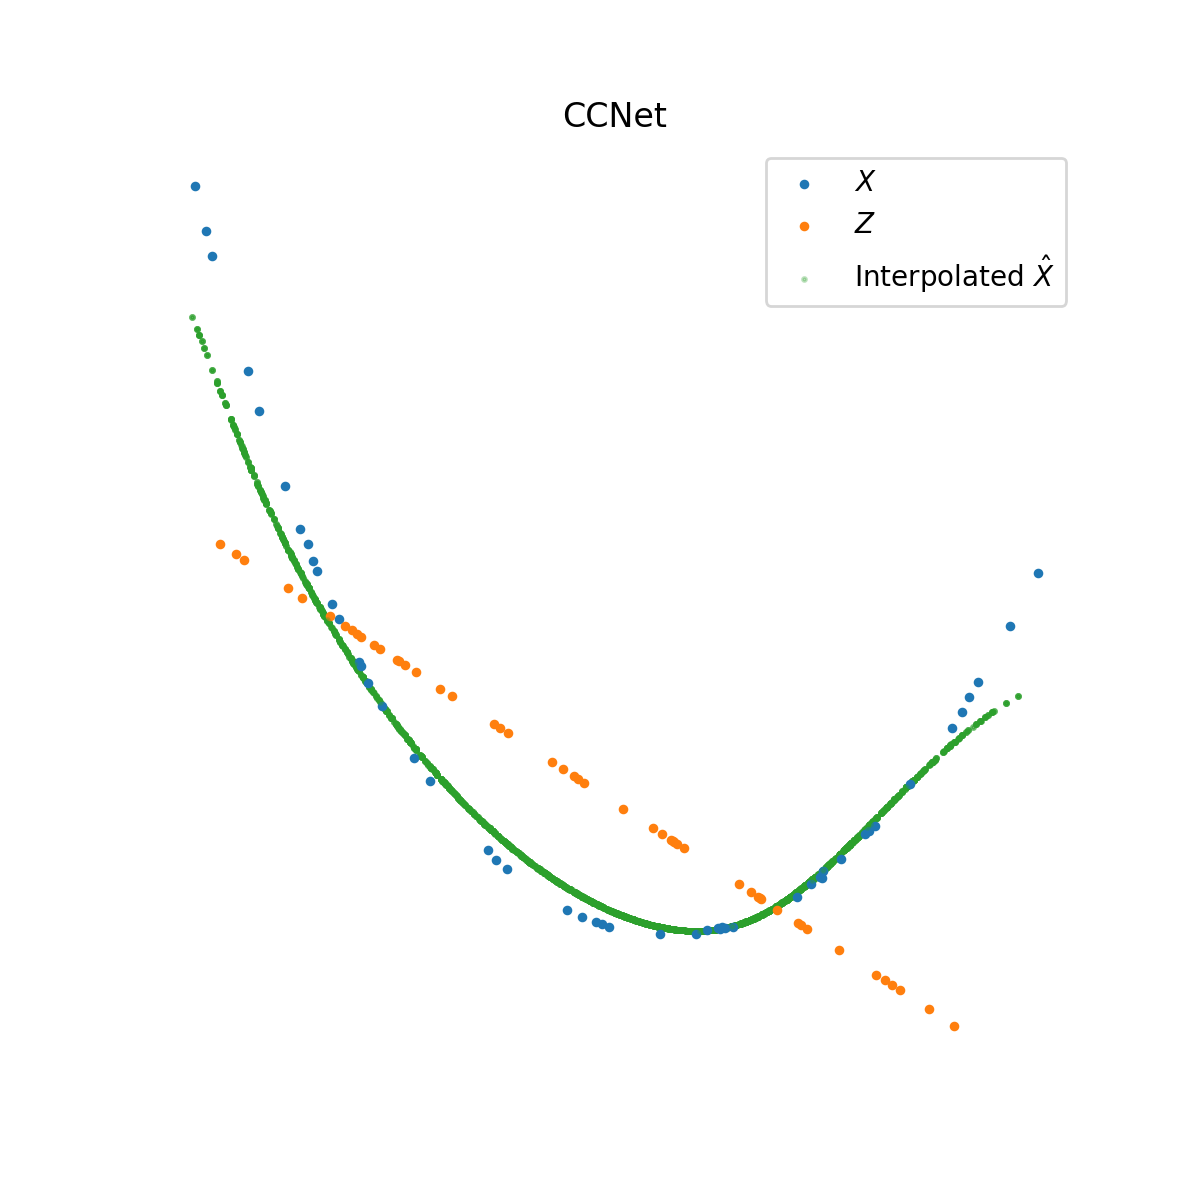

In [7]:
plot_X_Z_Xhat_interpolated_2d(X, Z, Xhat, G, "FlatNet")

In [8]:
F, G = train_vanilla_vae(X, d_latent=D_vae_latent, d_z=d, num_epochs=N_vanillavae_epochs)
Z = F(X)
Xhat = G(Z)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 41.3 K
1 | fc_mu   | Linear     | 101   
2 | fc_var  | Linear     | 101   
3 | decoder | Sequential | 41.6 K
---------------------------------------
83.1 K    Trainable params
0         Non-trainable params
83.1 K    Total params
0.332     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


<IPython.core.display.Javascript object>


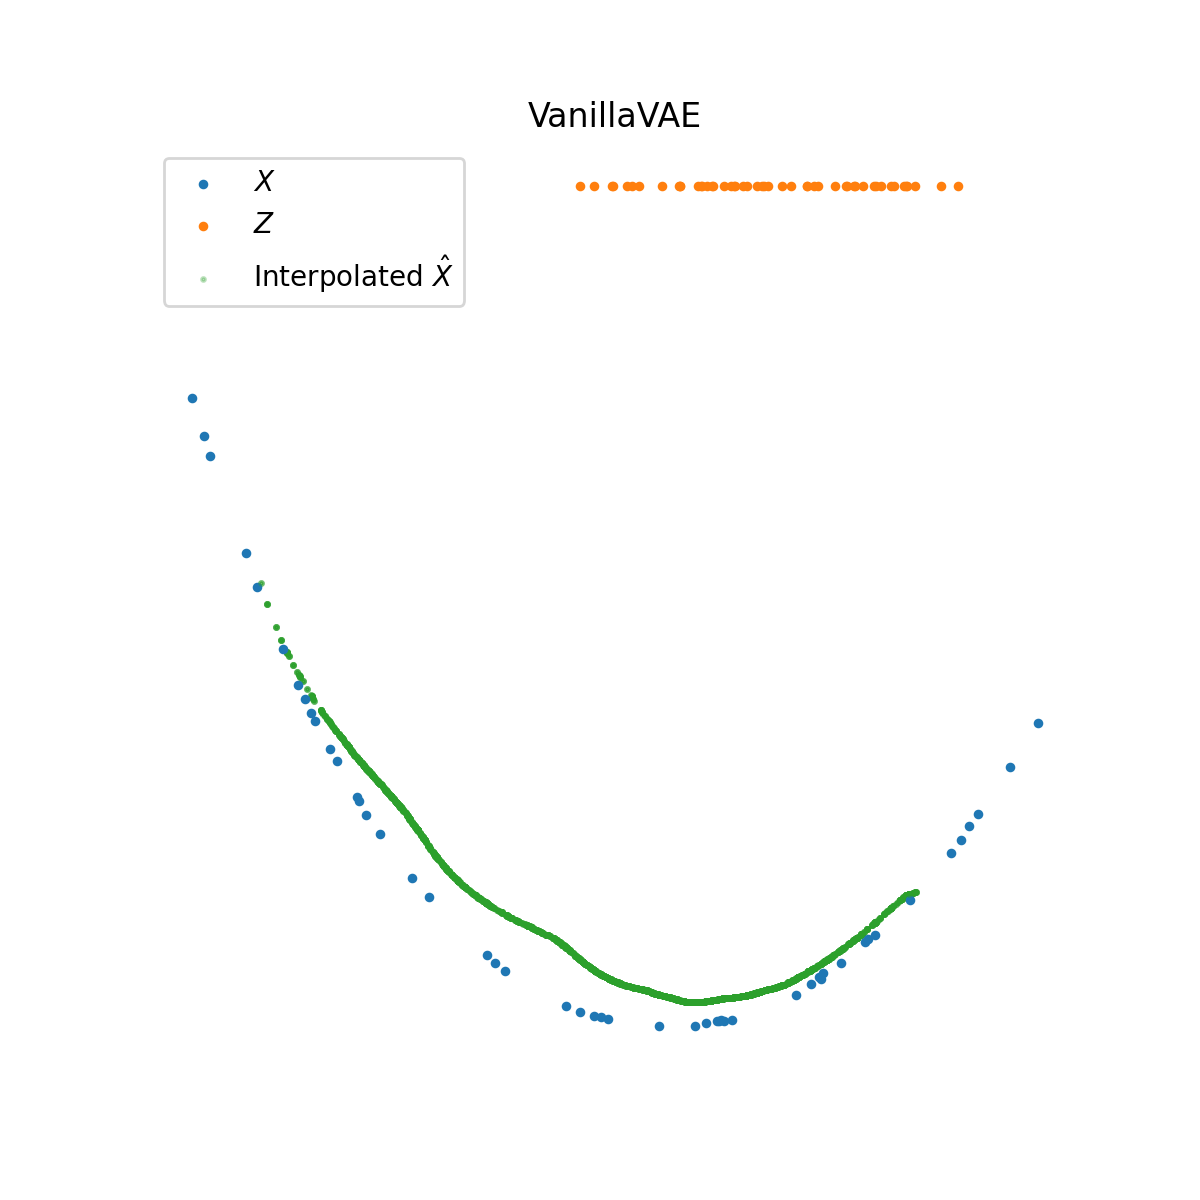

In [9]:
plot_X_Z_Xhat_interpolated_2d(X, Z, Xhat, G, "VanillaVAE")

In [10]:
F, G = train_beta_vae(X, d_latent=D_vae_latent, d_z=d, num_epochs=N_betavae_epochs)
Z = F(X)
Xhat = G(Z)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 41.3 K
1 | fc_mu   | Linear     | 101   
2 | fc_var  | Linear     | 101   
3 | decoder | Sequential | 41.6 K
---------------------------------------
83.1 K    Trainable params
0         Non-trainable params
83.1 K    Total params
0.332     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


<IPython.core.display.Javascript object>


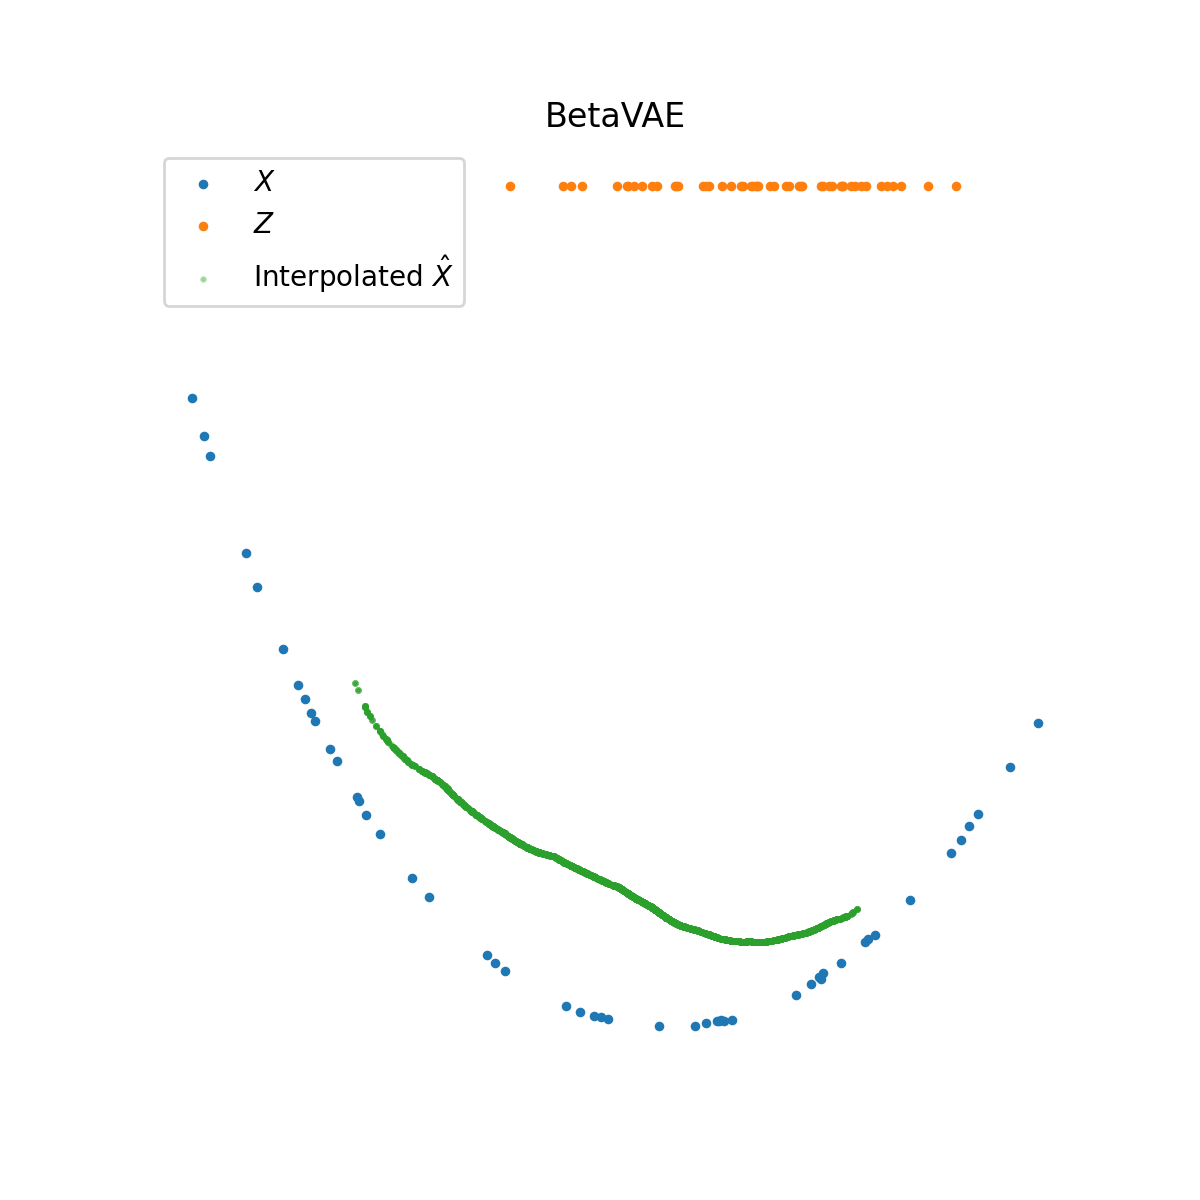

In [11]:
plot_X_Z_Xhat_interpolated_2d(X, Z, Xhat, G, "BetaVAE")

In [12]:
F, G = train_factor_vae(X, d_latent=D_vae_latent, d_z=d,  num_epochs=N_factorvae_epochs)
Z = F(X)
Xhat = G(Z)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 41.3 K
1 | fc_mu         | Linear     | 101   
2 | fc_var        | Linear     | 101   
3 | decoder       | Sequential | 41.6 K
4 | discriminator | Sequential | 41.6 K
---------------------------------------------
124 K     Trainable params
0         Non-trainable params
124 K     Total params
0.499     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


<IPython.core.display.Javascript object>


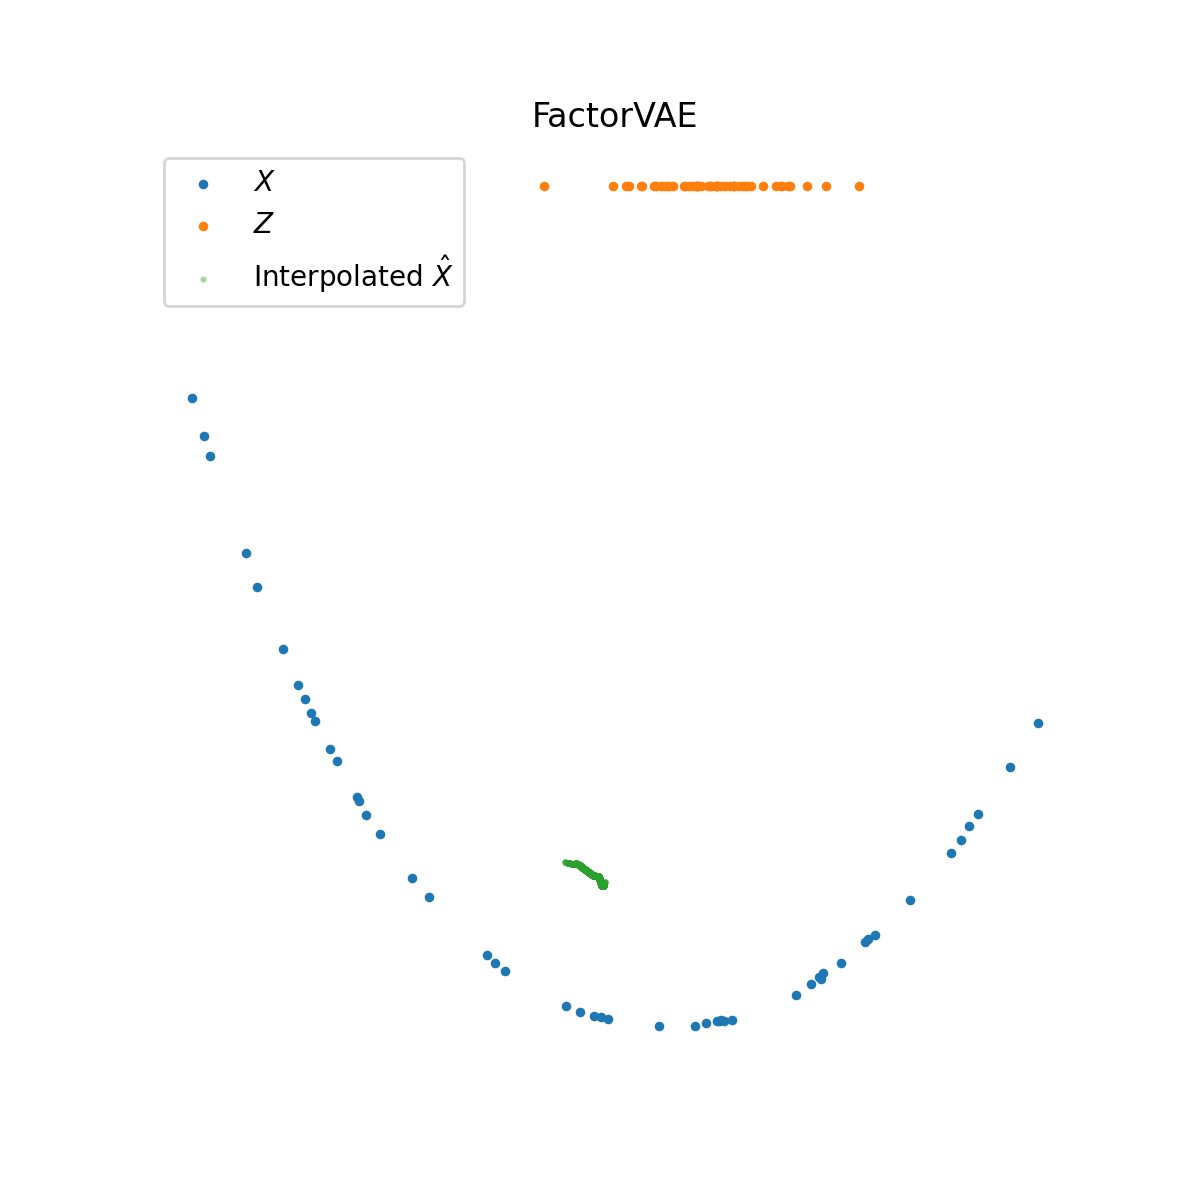

In [13]:
plot_X_Z_Xhat_interpolated_2d(X, Z, Xhat, G, "FactorVAE")

In [14]:
D = 3
d = 2

X, P, d = sample_points(N, D, d, [L_manifoldgen for _ in range(D)])

In [15]:
F, G = train(X)
Z = F(X)
Xhat = G(Z)

 96%|▉| 482/500 [01:58<00:04,  4.08iters/s, local_recon=8.25e-10, d=2, r_ratio=1


<IPython.core.display.Javascript object>


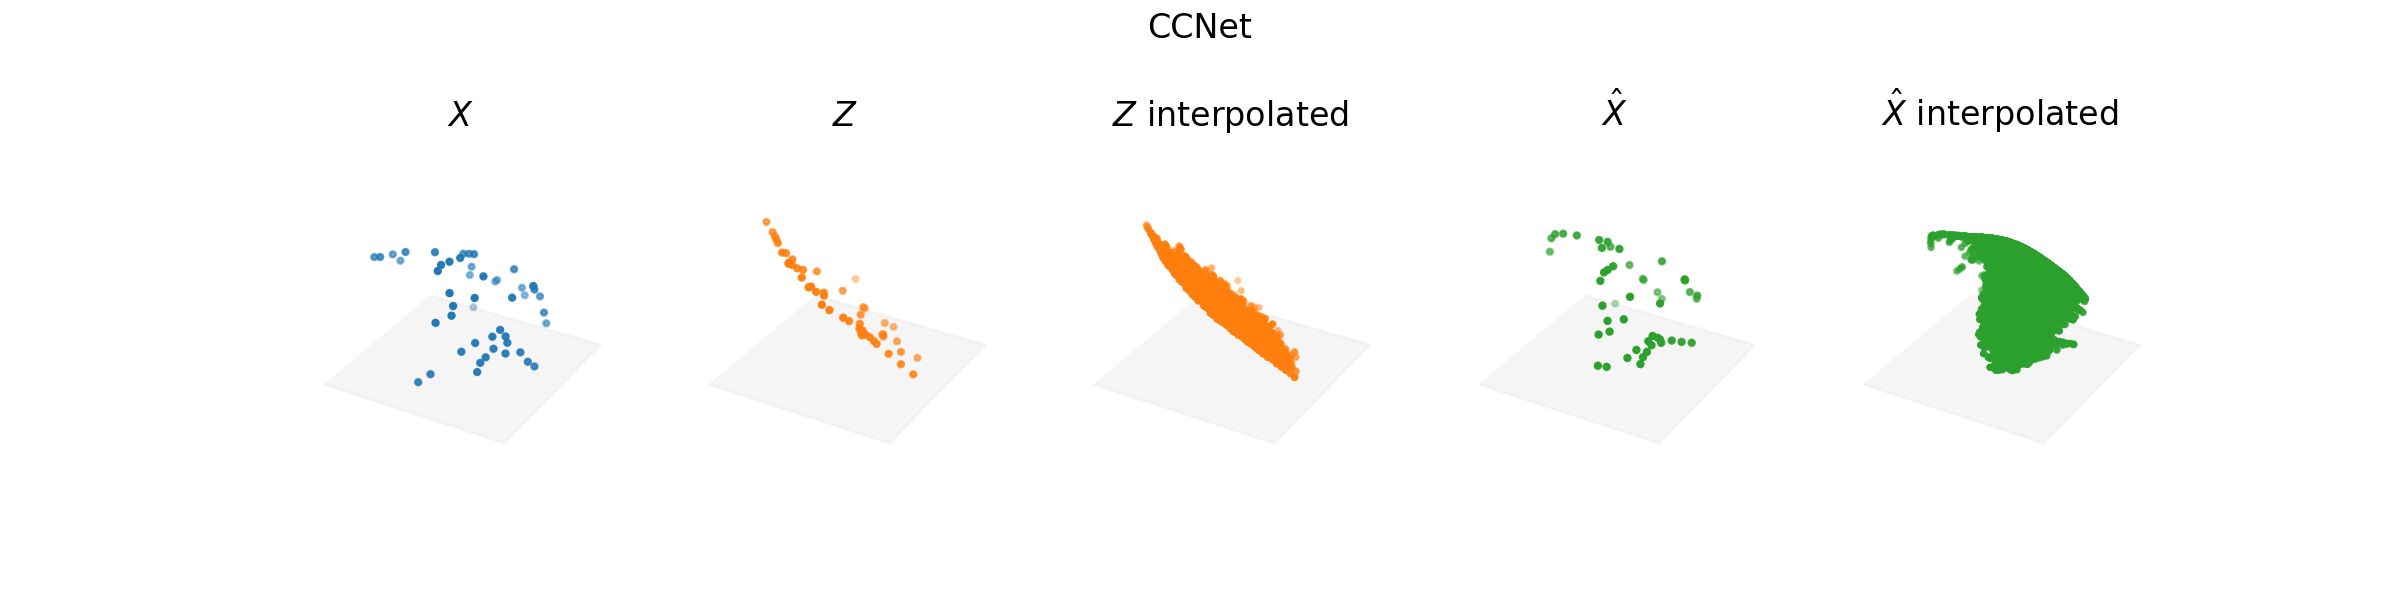

In [16]:
plot_X_Z_Xhat_interpolated_3d(X, Z, Xhat, G, "FlatNet")

In [17]:
F, G = train_vanilla_vae(X, d_latent=D_vae_latent, d_z=d, num_epochs=N_vanillavae_epochs)
Z = F(X)
Xhat = G(Z)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 41.4 K
1 | fc_mu   | Linear     | 202   
2 | fc_var  | Linear     | 202   
3 | decoder | Sequential | 41.8 K
---------------------------------------
83.6 K    Trainable params
0         Non-trainable params
83.6 K    Total params
0.334     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


<IPython.core.display.Javascript object>


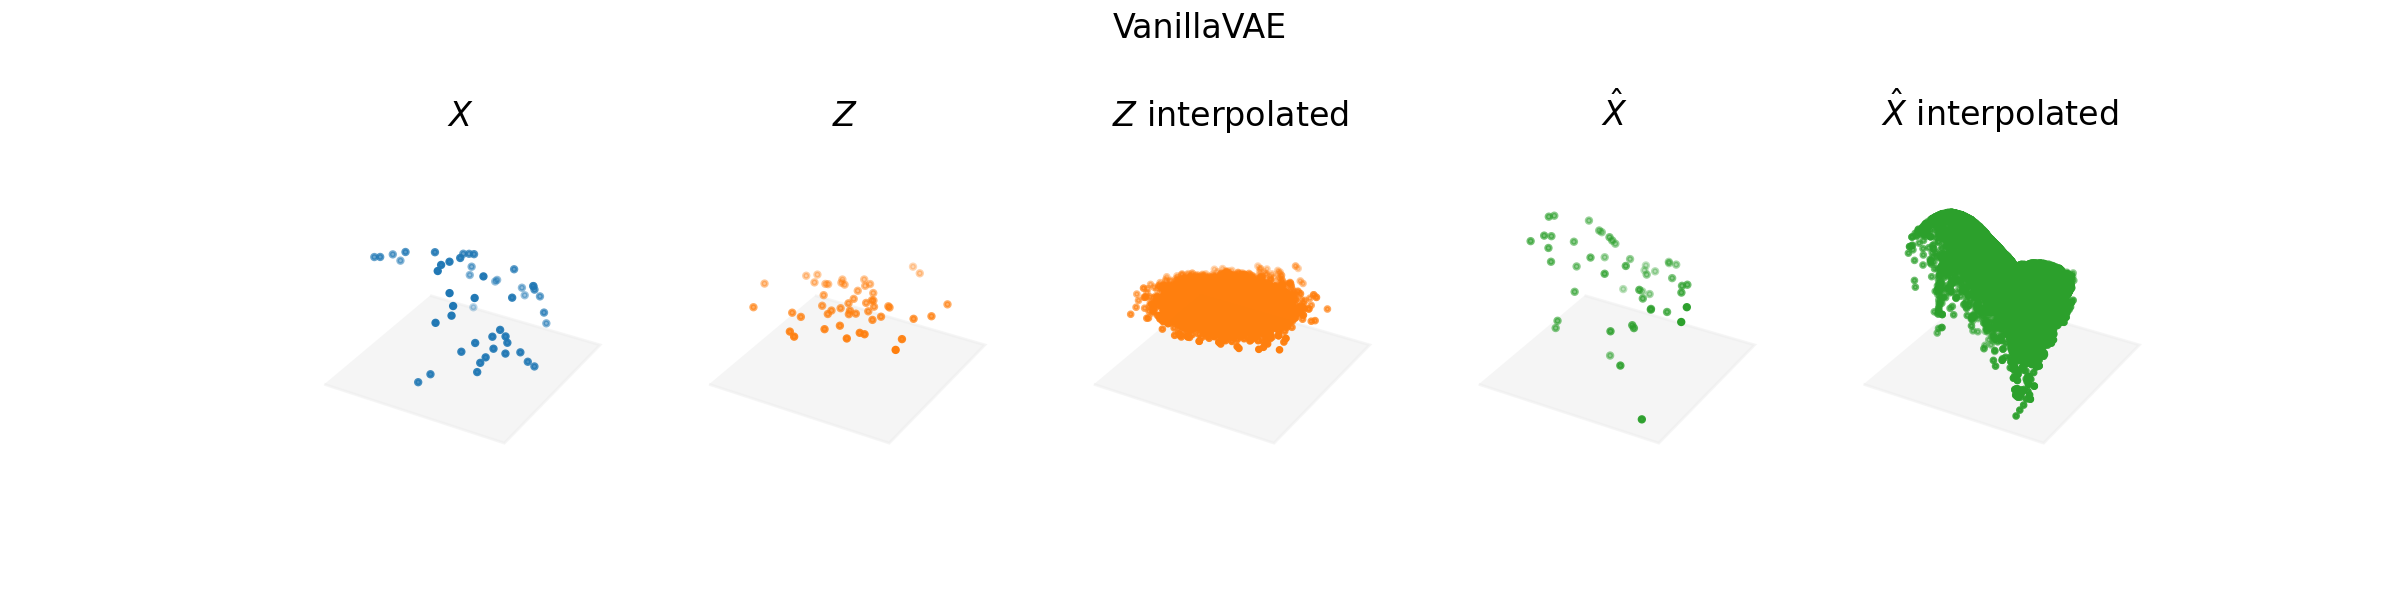

In [18]:
plot_X_Z_Xhat_interpolated_3d(X, Z, Xhat, G, "VanillaVAE")

In [19]:
F, G = train_beta_vae(X, d_latent=D_vae_latent, d_z=d, num_epochs=N_betavae_epochs)
Z = F(X)
Xhat = G(Z)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 41.4 K
1 | fc_mu   | Linear     | 202   
2 | fc_var  | Linear     | 202   
3 | decoder | Sequential | 41.8 K
---------------------------------------
83.6 K    Trainable params
0         Non-trainable params
83.6 K    Total params
0.334     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


<IPython.core.display.Javascript object>


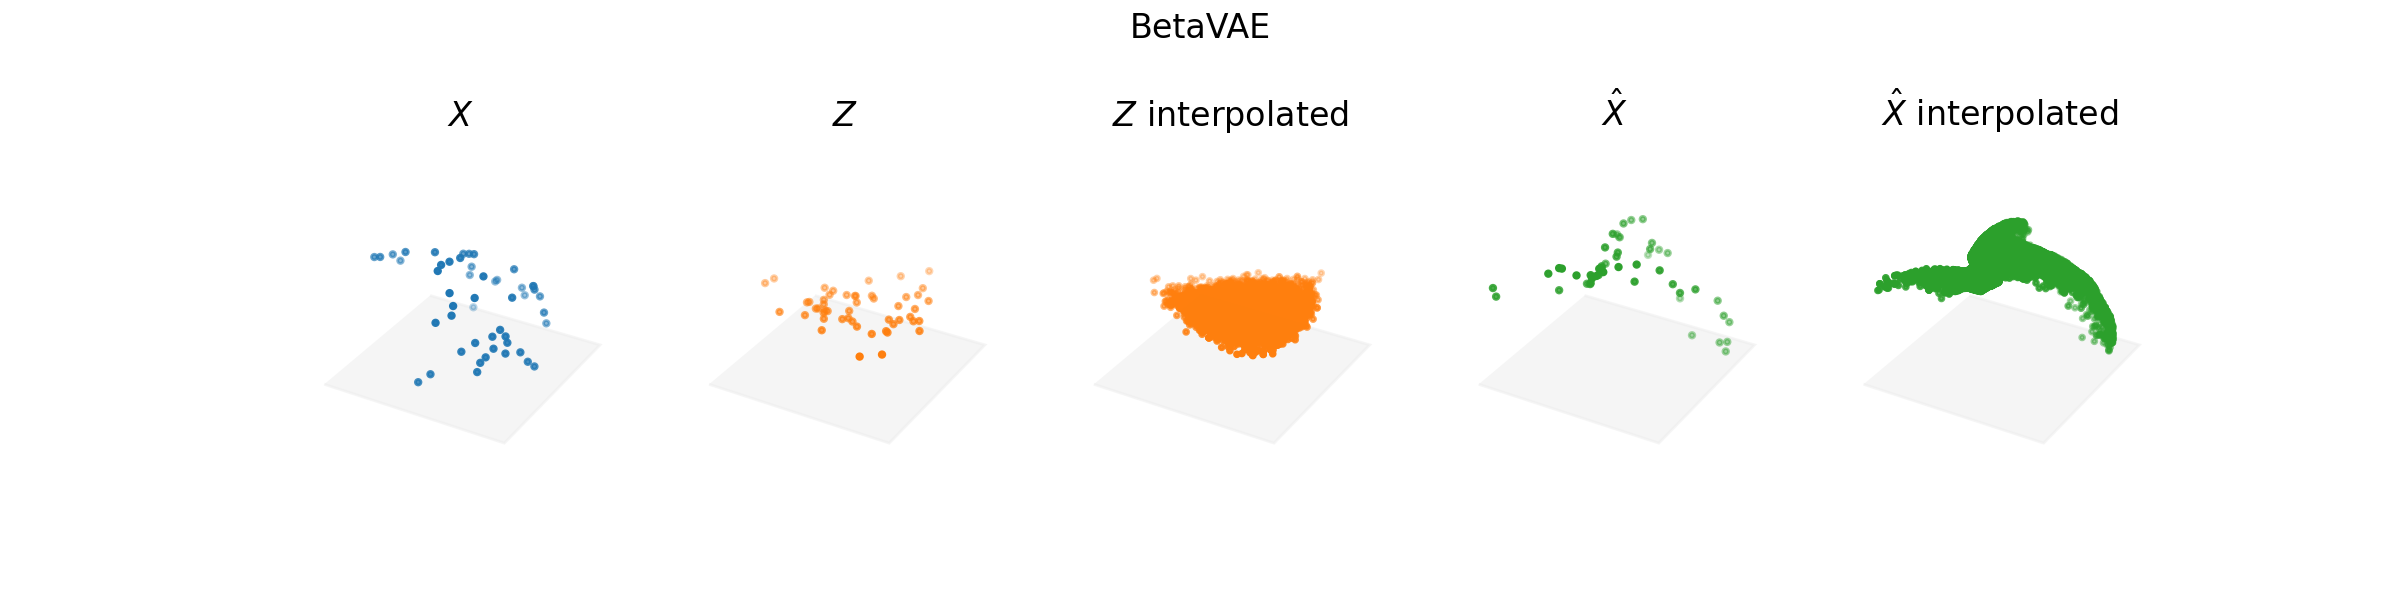

In [20]:
plot_X_Z_Xhat_interpolated_3d(X, Z, Xhat, G, "BetaVAE")

In [21]:
F, G = train_factor_vae(X, d_latent=D_vae_latent, d_z=d, num_epochs=N_factorvae_epochs)
Z = F(X)
Xhat = G(Z)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 41.4 K
1 | fc_mu         | Linear     | 202   
2 | fc_var        | Linear     | 202   
3 | decoder       | Sequential | 41.8 K
4 | discriminator | Sequential | 41.7 K
---------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.501     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


<IPython.core.display.Javascript object>


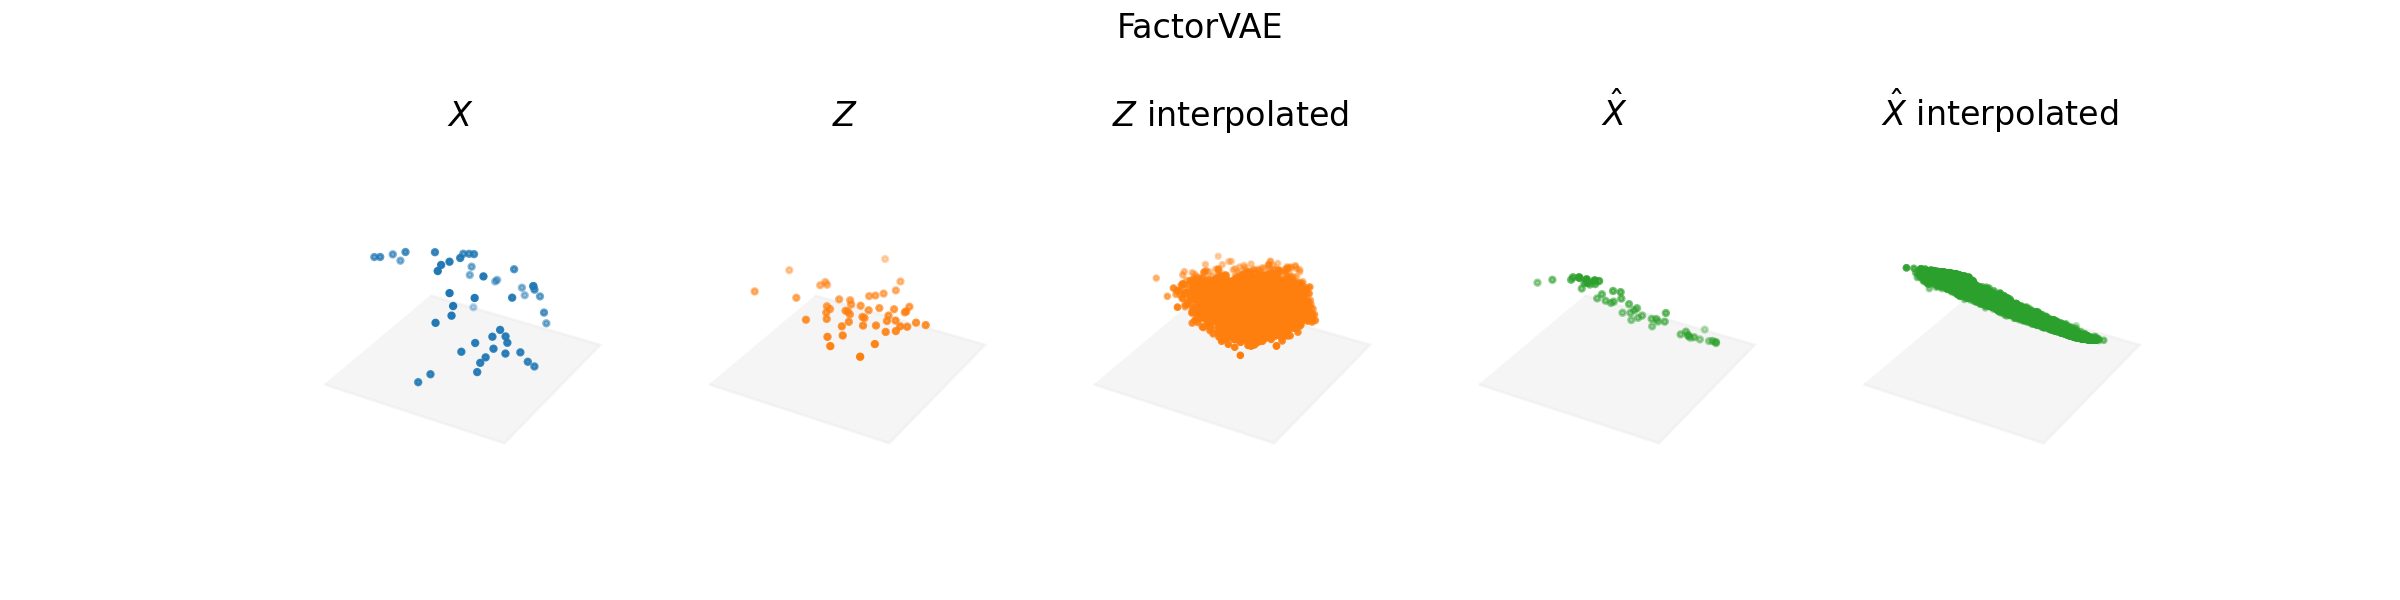

In [22]:
plot_X_Z_Xhat_interpolated_3d(X, Z, Xhat, G, "FactorVAE")